# Ha-Oiii temperature from 70 micron slits

The results I had before from the interpolated PV diagram was spurious. So I am going back to the individual spectra. 

In [2]:
from pathlib import Path
import numpy as np
from astropy.io import fits
from astropy.wcs import WCS
from astropy import constants
import astropy.units as u
from matplotlib import pyplot as plt
import seaborn as sns

In [3]:
sns.set_color_codes()
sns.set_context("talk")

In [4]:
datadir = Path.cwd().parent / "data/originals"
_files = sorted(datadir.glob("crN1004*.fits"))
[_.stem for _ in _files]

['crN10042_b', 'crN10043_bx', 'crN10045_bx-oiii', 'crN10047o']

## Extract 1d Ha line profile

### Read files and set up wavelength and velocity scale

In [5]:
hdu = fits.open(_files[1])[0]

In [6]:
w = WCS(hdu.header)
ny, nx = hdu.data.shape
_, waves = w.pixel_to_world_values([0]*ny, np.arange(ny))
offsets, _ = w.pixel_to_world_values(np.arange(nx), [0]*nx)

In [7]:
light_speed_kms = constants.c.to_value(u.km / u.s)
wave0 = 6562.78
vels = light_speed_kms * (waves - wave0) / wave0

### Choose extraction window along slit

This is the extraction window for the spectrum, which is calculated below from the spatial profile of oiii, and is then checked against ha in the section "Compare O and H slit profiles"

But I make it slightly wider by a couple of pixels

We want to maximize the s/n, given as (H, O):
* +20: (24.18891367543516, 18.191910107317998)
* +10: (26.149122388238688, 22.737316274209395)
* +5: (28.438370645632812, 25.359650214159032)
* +0: (33.18584854827538, 27.982091651173654)
* -3: (28.66752546398541, 24.957199441709353)
* -5: (37.45955799870539, 29.542278496464878)
* -6: (37.065848557373215, 30.308486959837605)
* -7: (37.4287582764283, 29.671969029824634)
* -10: (30.05426089705963, 24.100198832999215)
* -12: (25.48304300176179, 18.260139961930918)

So it does look like -5 is best, which is just 17 pixels at peak

In [8]:
# i1, i2 = 487, 507
extra = -6
i1, i2 = 483 - extra, 510 + extra
f"Window size: {i2 - i1} pixels"

'Window size: 15 pixels'

### Remove the ISM line

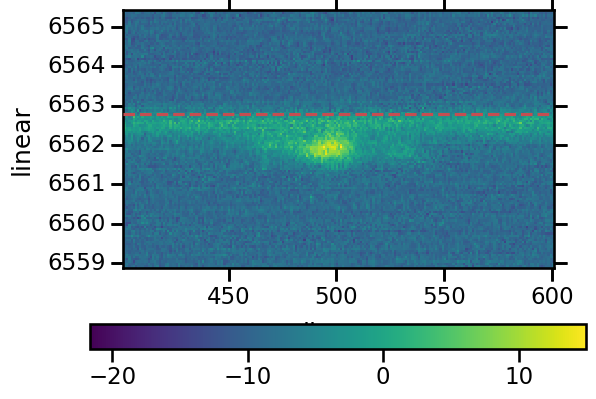

In [9]:
# wav_window = slice(330, 390)
# pos_window = slice(440, 560)
# convert to default float since fits image was big endian
im = hdu.data.astype("float")
# bg = p(pixels)[wav_window, None]
# im -= bg
fig, ax = plt.subplots(subplot_kw=dict(projection=w))
_ = ax.imshow(im, interpolation="none")
ax.set_xlim(400, 600)
ax.set_ylim(300, 420)
x0, y0 = w.world_to_pixel_values(0, wave0)
ax.axhline(y0, color="r", ls="dashed")
fig.colorbar(_, ax=ax, orientation="horizontal")

In [10]:
bg = np.median(im, axis=1, keepdims=True)

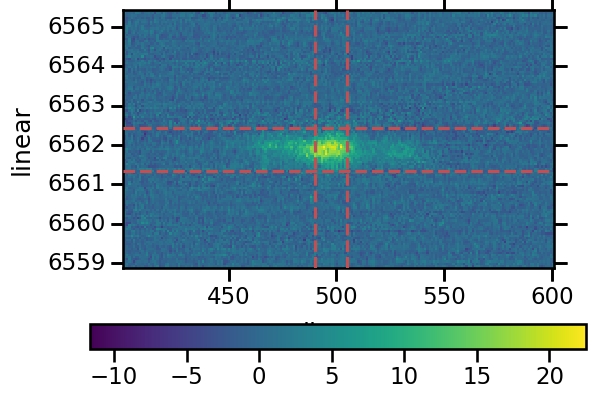

In [11]:
fig, ax = plt.subplots(subplot_kw=dict(projection=w))
_ = ax.imshow(im - bg, interpolation="none")
ax.set_xlim(400, 600)
ax.set_ylim(300, 420)
x0, y0 = w.world_to_pixel_values(0, wave0)
ax.axhline(345, color="r", ls="dashed")
ax.axhline(365, color="r", ls="dashed")
ax.axvline(i1, color="r", ls="dashed")
ax.axvline(i2, color="r", ls="dashed")
fig.colorbar(_, ax=ax, orientation="horizontal")

In [12]:
noise_var = 1.6 + 0.17 * im
imm = im - bg

### Spatial profile

In [13]:
yslice = slice(345, 365)
# yslice = slice(350, 360)
profile = np.sum(imm[yslice, :], axis=0)
sprofile = np.sqrt(np.sum(noise_var[yslice, :], axis=0))

/var/folders/0q/3pcjvc3n6sn2wk6g8ck6ry300000gn/T/ipykernel_58295/186753298.py:4: RuntimeWarning: invalid value encountered in sqrt
  sprofile = np.sqrt(np.sum(noise_var[yslice, :], axis=0))


In [14]:
is_bright = profile >= 0.5 * np.max(profile)
ii1 = np.min(offsets[is_bright]).astype(int)
ii2 = np.max(offsets[is_bright]).astype(int)
ii1, ii2

(483, 507)

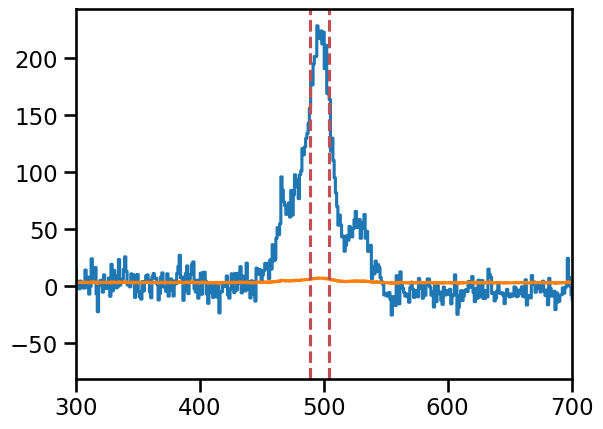

In [15]:
fig, ax = plt.subplots()
ds = "steps-mid"             
ax.plot(offsets, profile, ds=ds)
ax.plot(offsets, sprofile, ds=ds)
# ax.fill_between(offsets, profile + sprofile, profile - sprofile)
ax.set_xlim(300, 700)
ax.axvline(i1, color="r", ls="dashed")
ax.axvline(i2, color="r", ls="dashed")

In [16]:
np.std(profile[300:450]), np.mean(profile[300:450])

(9.326378734745425, 2.7024016467109324)

In [17]:
np.nanmean(sprofile[300:450])

3.08519937157776

In [18]:
np.nanstd(imm[yslice, 300:450]), np.nanmean(imm[yslice, 300:450])

(1.602172638731623, 0.13512008233554662)

Save these so we can reuse the variable names

In [19]:
offsets_h = offsets
slitprofile_h = profile

### Line profile

/var/folders/0q/3pcjvc3n6sn2wk6g8ck6ry300000gn/T/ipykernel_58295/551844711.py:6: RuntimeWarning: invalid value encountered in sqrt
  sprofile = np.sqrt(np.sum(noise_var[:, xslice], axis=1))


(6555.0, 6570.0)

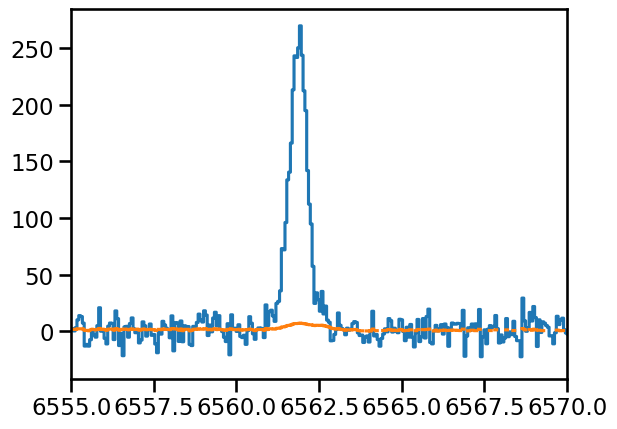

In [20]:
fig, ax = plt.subplots()
yslice = slice(345, 365)
xslice = slice(i1, i2)
# yslice = slice(350, 360)
profile = np.sum(imm[:, xslice], axis=1)
sprofile = np.sqrt(np.sum(noise_var[:, xslice], axis=1))
ds = "steps-mid"             
ax.plot(waves, profile, ds=ds)
ax.plot(waves, sprofile, ds=ds)
ax.set_xlim(6555, 6570)

(-150.0, 150.0)

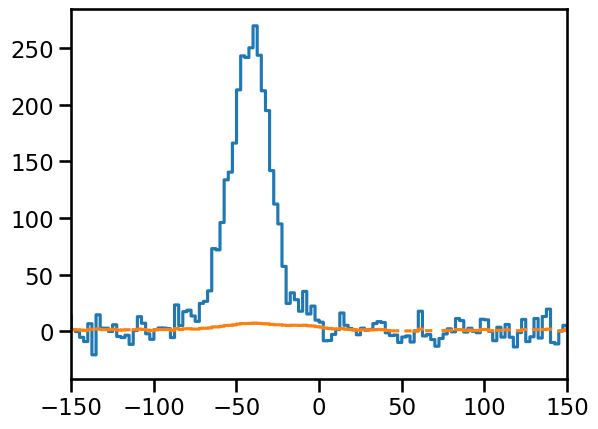

In [21]:
fig, ax = plt.subplots()
ax.plot(vels, profile, ds=ds)
ax.plot(vels, sprofile, ds=ds)
ax.set_xlim(-150, 150)

In [22]:
window = (vels > -100) & (vels < 0)
vmean_ha = np.average(vels[window], weights=profile[window])
vmean_ha

-41.88770840341874

In [23]:
idata, vdata = {}, {}

In [24]:
idata["ha"] = profile / np.sum(profile[window])
vdata["ha"] = vels - vmean_ha

## Extract 1d Oiii profile

### Read files and set up wavelength and velocity scale

In [25]:
hdu = fits.open(_files[2])[0]

In [26]:
w = WCS(hdu.header)
ny, nx = hdu.data.shape
_, waves = w.pixel_to_world_values([0]*ny, np.arange(ny))
offsets, _ = w.pixel_to_world_values(np.arange(nx), [0]*nx)

In [27]:
light_speed_kms = constants.c.to_value(u.km / u.s)
wave0 = 5006.8
vels = light_speed_kms * (waves - wave0) / wave0

### Remove the ISM line

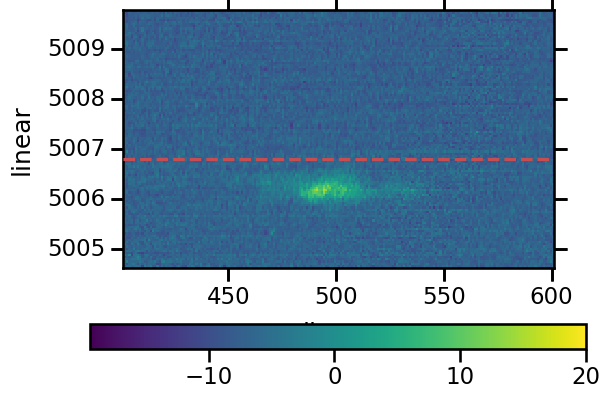

In [28]:
# convert to default float since fits image was big endian
im = hdu.data.astype("float")
fig, ax = plt.subplots(subplot_kw=dict(projection=w))
_ = ax.imshow(im, interpolation="none", vmax=20)
ax.set_xlim(400, 600)
ax.set_ylim(300, 420)
x0, y0 = w.world_to_pixel_values(0, wave0)
ax.axhline(y0, color="r", ls="dashed")
fig.colorbar(_, ax=ax, orientation="horizontal")

In [29]:
bg = np.median(im, axis=1, keepdims=True)

This comes from the spatial profile section below. It is the half-intensity points. But I do not set it here, so there is only one place to set it

In [30]:

# i1, i2 = 483, 510

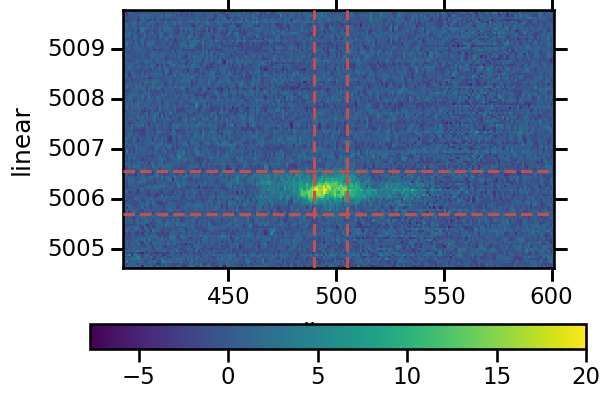

In [31]:
fig, ax = plt.subplots(subplot_kw=dict(projection=w))
_ = ax.imshow(im - bg, interpolation="none", vmax=20)
ax.set_xlim(400, 600)
ax.set_ylim(300, 420)
x0, y0 = w.world_to_pixel_values(0, wave0)
ax.axhline(325, color="r", ls="dashed")
ax.axhline(345, color="r", ls="dashed")
ax.axvline(i1, color="r", ls="dashed")
ax.axvline(i2, color="r", ls="dashed")
fig.colorbar(_, ax=ax, orientation="horizontal")

In [32]:
noise_var = 1.6 + 0.17 * im
imm = im - bg

### Spatial profile

In [33]:
yslice = slice(325, 345)
# yslice = slice(350, 360)
profile = np.sum(imm[yslice, :], axis=0)
sprofile = np.sqrt(np.sum(noise_var[yslice, :], axis=0))


In [34]:
is_bright = profile >= 0.5 * np.max(profile)
ii1 = np.min(offsets[is_bright]).astype(int)
ii2 = np.max(offsets[is_bright]).astype(int)
ii1, ii2

(483, 510)

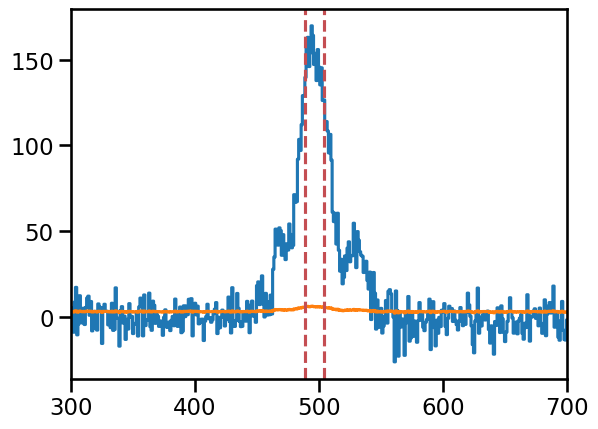

In [35]:
fig, ax = plt.subplots()

ds = "steps-mid"             
ax.plot(offsets, profile, ds=ds)
ax.plot(offsets, sprofile, ds=ds)
# ax.fill_between(offsets, profile + sprofile, profile - sprofile)
ax.set_xlim(300, 700)
ax.axvline(i1, color="r", ls="dashed")
ax.axvline(i2, color="r", ls="dashed")

In [36]:
np.std(profile[300:450]), np.mean(profile[300:450])

(7.128583680442333, 0.3124381017684936)

In [37]:
np.nanmean(sprofile[300:450])

3.009991714265315

In [38]:
np.nanstd(imm[yslice, 300:450]), np.nanmean(imm[yslice, 300:450])

(1.463515299408126, 0.015621905088424683)

In [39]:
offsets_o = offsets
slitprofile_o = profile

### Compare O and H slit profiles

I want to get a better handle on the best spatial window to use for extracting the spectrum, and to check that the slit profiles of the two lines are similar enough.

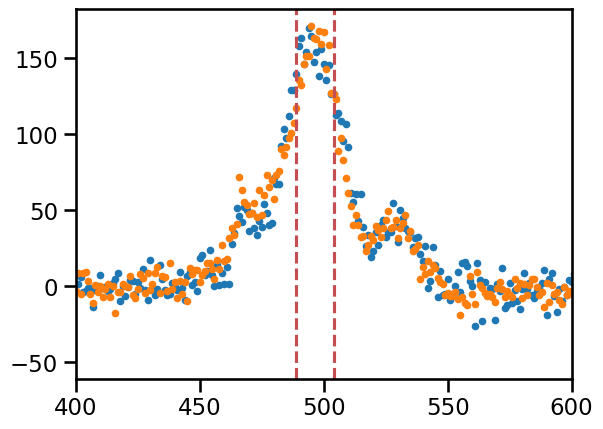

In [40]:
fig, ax = plt.subplots()

ds = "steps-mid"             
ax.plot(offsets_o, slitprofile_o, ".")
ax.plot(offsets_h, 0.75 * slitprofile_h, ".")

ax.set_xlim(400, 600)
ax.axvline(i1, color="r", ls="dashed")
ax.axvline(i2, color="r", ls="dashed")

So after multiplying Ha by 0.75, we get a fery close agreement between the two. This is strong evidence that the slit positions coincide. 

We are showing ii1, ii2, which were calculated as the half power points of the oiii profile. These look like good choices for integrating the line profiles. So, i will canonize them as i1 and i2, which I will insert above.

In [41]:
ii1, ii2

(483, 510)

### Line profile

/var/folders/0q/3pcjvc3n6sn2wk6g8ck6ry300000gn/T/ipykernel_58295/1846245743.py:7: RuntimeWarning: invalid value encountered in sqrt
  sprofile = np.sqrt(np.sum(noise_var[:, xslice], axis=1))


(5000.0, 5015.0)

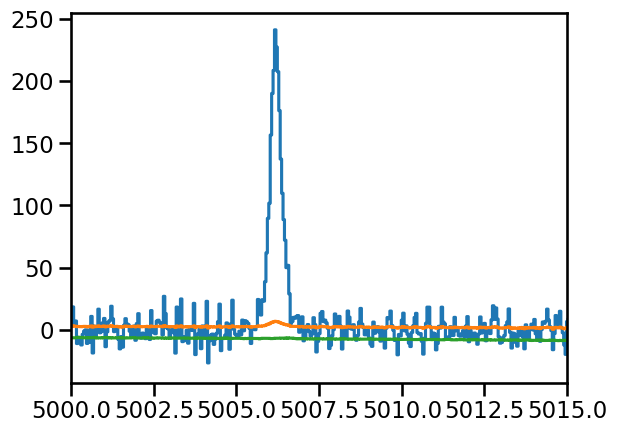

In [42]:
fig, ax = plt.subplots()
yslice = slice(325, 345)
xslice = slice(i1, i2)
# yslice = slice(350, 360)
profile = np.sum(imm[:, xslice], axis=1)
profile0 = np.sum(im[:, xslice], axis=1)
sprofile = np.sqrt(np.sum(noise_var[:, xslice], axis=1))
ds = "steps-mid"             
ax.plot(waves, profile, ds=ds)
ax.plot(waves, sprofile, ds=ds)
ax.plot(waves, bg, ds=ds)
ax.set_xlim(5000, 5015)

(-150.0, 150.0)

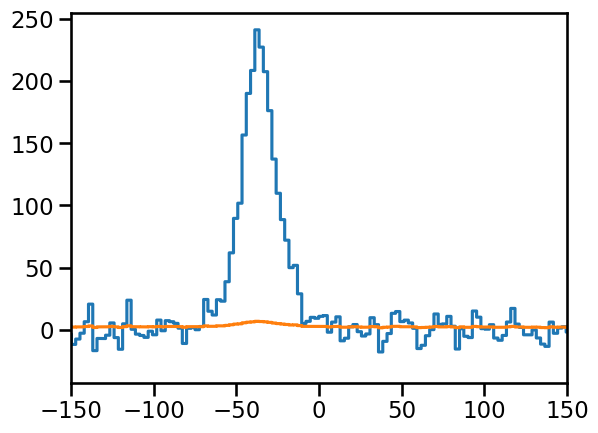

In [43]:
fig, ax = plt.subplots()
ax.plot(vels, profile, ds=ds)
ax.plot(vels, sprofile, ds=ds)
ax.set_xlim(-150, 150)

In [44]:
window = (vels > -100) & (vels < 0)
vmean_oiii = np.average(vels[window], weights=profile[window])
vmean_oiii

-36.58329835487929

In [45]:
idata["oiii"] = profile / np.sum(profile[window])
vdata["oiii"] = vels - vmean_oiii

## Compare two lines

(-70.0, 70.0)

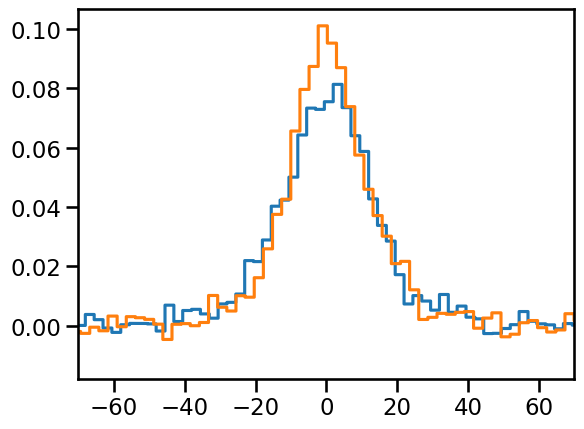

In [46]:
fig, ax = plt.subplots()
ax.plot(vdata["ha"], idata["ha"], ds=ds)
ax.plot(vdata["oiii"], idata["oiii"], ds=ds)
ax.set_xlim(-70, 70)

Turns out that the pixels are not quite the same size in velocity

In [47]:
np.diff(vdata["oiii"])[0], np.diff(vdata["ha"])[0]

(2.579591702433163, 2.498936314386242)

In [48]:
np.diff(vdata["oiii"])[0] / np.diff(vdata["ha"])[0]

1.0322758877777687

### Fit single Gaussians to get a better estimate of the central velocity of each line

In [49]:
from astropy.modeling import models, fitting

In [50]:
fitter = fitting.LevMarLSQFitter()
gfits = {}
for lineid in vdata.keys():
    gfits[lineid] = fitter(
        models.Gaussian1D(amplitude=0.1, mean=0.0, stddev=10.0), 
        vdata[lineid], idata[lineid],
    )


In [51]:
gfits

{'ha': <Gaussian1D(amplitude=0.07693991, mean=0.54744898, stddev=12.42020082)>,
 'oiii': <Gaussian1D(amplitude=0.09320119, mean=0.26276618, stddev=10.60141544)>}

Set definitive velocity arrays for the two lines, centered on the mean velocity of the gaussian fit.

In [52]:
vel_h = vdata["ha"] - gfits["ha"].mean
vel_o = vdata["oiii"] - gfits["oiii"].mean

and short aliases for the intensity profiles, observed and fitted. This is because I am going to start smoothing and interpolating from one to another, so the long descriptors will get unwieldy

In [53]:
i_h = idata["ha"]
i_o = idata["oiii"]
g_h = gfits["ha"](vdata["ha"])
g_o = gfits["oiii"](vdata["oiii"])


Check that I have not messed up with the velocity shifts. The gaussian discrete profiles should be centered on zero, when evaluated on the shifted velocity arrays

In [54]:
np.average(vel_h, weights=g_h), np.average(vel_o, weights=g_o)

(8.473568620421444e-120, 2.5204622679800625e-16)

Those are reassuringly small

### CANCELLED - Final refinement to velocity zero points

But we also want to see how the mean velocities of the observed lines compare in a restricted window. 

In [55]:
is_bright_h = g_h > 0.01
dv_h = np.average(vel_h[is_bright_h], weights=i_h[is_bright_h])
is_bright_o = g_o > 0.01
dv_o = np.average(vel_o[is_bright_o], weights=i_o[is_bright_o])
dv_h, dv_o

(-0.6041483016512649, 0.3810458637467764)

That is what I suspected, that there is a slight difference. This is due to a tension between the wings and the peak. *However, it is very sensitive to the threshold brightness that I choose*

I will experiment with an alternative centering that uses these mean values. 

In [56]:
vel_hh = vdata["ha"] - gfits["ha"].mean - dv_h
vel_oo = vdata["oiii"] - gfits["oiii"].mean - dv_o

Sanity check to make sure I have applied shifts in the right direction:

In [57]:
check_h = np.average(vel_hh[is_bright_h], weights=i_h[is_bright_h])
check_o = np.average(vel_oo[is_bright_o], weights=i_o[is_bright_o])
check_h, check_o

(-1.2213368723119412e-16, 1.7815254472974481e-16)

I am not totally convinced that this is the best thing to do, since it will make the discrepancy at the peak larger, but it should help with the wings. **No, it makes everything worse, so I am not using it**

### Refine normalization of the line

We previously did this over the entire spectrum, which is probably inaccurate since it is bringing in a load of irrelevant fluctuations.

So check the normalization over the core of the line. We can try it two ways – from the data or from the gaussian fits. For the data, we use `trapz` to integrate, which takes into account the different bin widths

In [58]:
is_core_h = (np.abs(vel_h) < 40)
is_core_o = (np.abs(vel_o) < 40)
factor = (
    np.trapz(i_h[is_core_h], vel_h[is_core_h]) 
    / np.trapz(i_o[is_core_o], vel_o[is_core_o])
)
factor2 = (
    gfits["ha"].stddev * gfits["ha"].amplitude 
    / (gfits["oiii"].stddev * gfits["oiii"].amplitude)
)
factor, factor2

(0.9549163379625497, 0.9671526223074827)

These are very similar to one another. So, we will adjust the brightness of the Ha profile to give the same normalization as Oiii

In [59]:
i_h = idata["ha"] / factor
g_h = gfits["ha"](vdata["ha"]) / factor


### Plot the profiles and fits

(-80.0, 80.0)

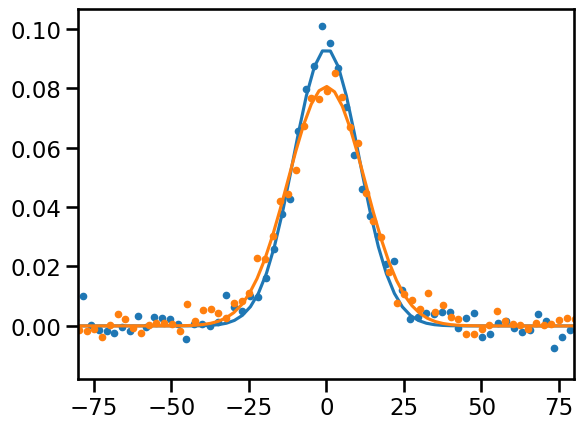

In [60]:
fig, ax = plt.subplots()


# line, = ax.plot(vel_o, i_o, ds="steps-mid")
line, = ax.plot(vel_o, i_o, ".")
ax.plot(vel_o, g_o, color=line.get_color())

# line, = ax.plot(vel_h, i_h, ds="steps-mid")
line, = ax.plot(vel_h, i_h, ".")
ax.plot(vel_h, g_h, color=line.get_color())

ax.set_xlim(-80, 80)

RMS widths of the gaussian fits

In [61]:
sig_h = gfits["ha"].stddev
sig_o = gfits["oiii"].stddev
sig_extra = np.sqrt(sig_h ** 2 - sig_o ** 2)
sig_h.value, sig_o.value, sig_extra

(12.42020082078369, 10.601415440894584, 6.470809769894162)

Simple measurement of temperature

In [62]:
T4 = (sig_extra**2 - 10.2) / 77.34
T4

0.4095083925285459

So that is pretty cold! 4000 K, but we have no error bars. We will get those from the convolution

### Check the noise levels

In [63]:
from noise_utils import sliding_std

In [64]:
sliding_std(np.arange(6))

array([nan,  1.,  1.,  1.,  1., nan])

Calculate sigma of residuals between observations and gaussian fit with a n-point sliding window

In [65]:
nwin = 3
s_h = sliding_std(i_h - g_h, nwin)
s_o = sliding_std(i_o - g_o, nwin)


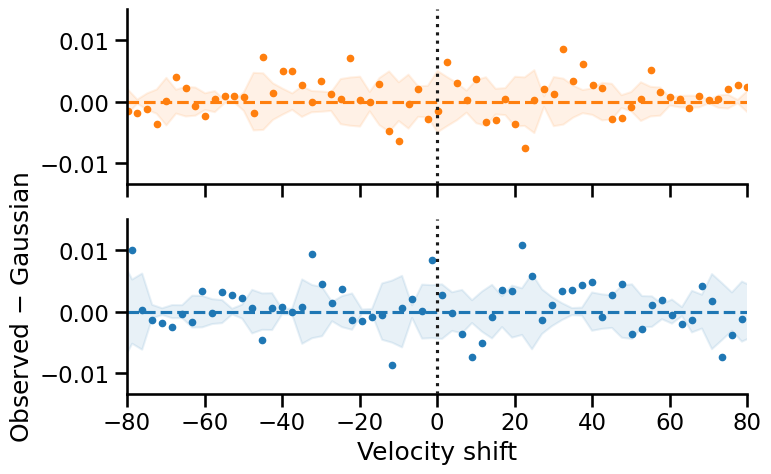

In [66]:
fig, (axh, axo) = plt.subplots(2, 1, figsize=(8, 5), sharex=True, sharey=True)

line, = axo.plot(vel_o, i_o - g_o, ".")
c = line.get_color()
axo.fill_between(vel_o, s_o, -s_o, color=c, alpha=0.1)
axo.axhline(0, color=c, linestyle="dashed")

c = "C1"
line, = axh.plot(vel_h, i_h - g_h, ".", color=c)
axh.fill_between(vel_h, s_h, -s_h, color=c, alpha=0.1)
axh.axhline(0, color=c, linestyle="dashed")

for ax in axh, axo:
    ax.axvline(0, color="k", linestyle="dotted", zorder=100)
axo.set_xlim(-80, 80)
axo.set_xlabel("Velocity shift")
axo.set_ylabel("Observed $-$ Gaussian")
sns.despine()

The residuals do not increase significantly in the line core, which means they must be dominated by noise and that the noise is roughly constant

In [67]:
is_outer_h = (np.abs(vel_h) < 80) & (~is_core_h)
is_outer_o = (np.abs(vel_o) < 80) & (~is_core_o)
print(f"Outer pixels: {np.sum(is_outer_h)}, {np.sum(is_outer_o)}")
print(f"Core pixels: {np.sum(is_core_h)}, {np.sum(is_core_o)}")


Outer pixels: 32, 31
Core pixels: 32, 31


In [68]:
s_h_core = np.mean(s_h[is_core_h])
s_o_core = np.mean(s_o[is_core_o])
s_h_outer = np.mean(s_h[is_outer_h])
s_o_outer = np.mean(s_o[is_outer_o])
print(f"Outer rms residulas: {s_h_outer:.4f}, {s_o_outer:.4f}")
print(f"Core rms residuals: {s_h_core:.4f}, {s_o_core:.4f}")


Outer rms residulas: 0.0018, 0.0028
Core rms residuals: 0.0030, 0.0030


So they are slightly higher in the core of the line, which may be due to non-gaussian profile. So I will use the outer value to define the noise sigma

In [69]:
s_noise_outer = np.sqrt(s_h_outer**2 + s_o_outer**2)
s_noise_core = np.sqrt(s_h_core**2 + s_o_core**2)
s_noise_mean = np.mean([s_noise_outer, s_noise_core])
s_noise_outer, s_noise_core, s_noise_mean

(0.003316059730756974, 0.004261091652992349, 0.0037885756918746615)

In [70]:
s_noise = s_noise_outer

And we can calculate the S/N ratios. We use the gaussian peak, rather than the observed peak, since it is less influenced by noise

In [71]:
snr_h = np.max(g_h) / s_h_outer
snr_o = np.max(g_o) / s_o_outer
snr_h, snr_o

(44.51671330319465, 33.301083830189164)

## Interpolate Ha onto Oiii velocities and vice versa

Since Ha is slightly broader, it should be less affected by the interpolation

In [72]:
i_ho = np.interp(vel_o, vel_h, i_h)
i_oh = np.interp(vel_h, vel_o, i_o)

g_ho = np.interp(vel_o, vel_h, g_h)

(-80.0, 80.0)

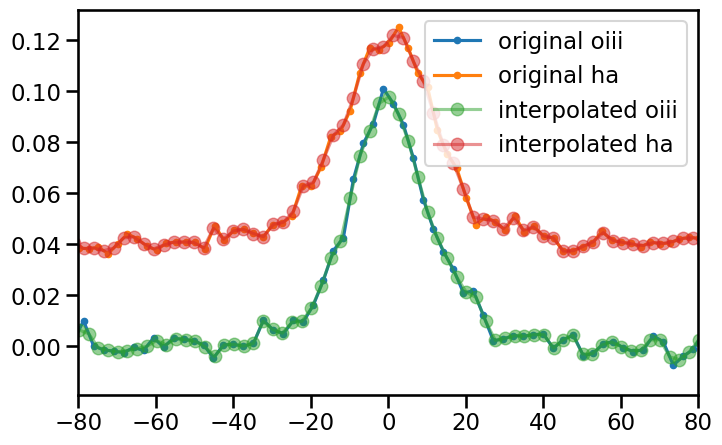

In [73]:
fig, ax = plt.subplots(figsize=(8, 5))
offset = 0.04


# line, = ax.plot(vel_o, i_o, ds="steps-mid")
line, = ax.plot(vel_o, i_o, ".-", label="original oiii")
line, = ax.plot(vel_h, offset + i_h, ".-", label="original ha")

line, = ax.plot(vel_h, i_oh, "o-", label="interpolated oiii", alpha=0.5)
line, = ax.plot(vel_o, offset + i_ho, "o-", label="interpolated ha", alpha=0.5)
ax.legend()
ax.set_xlim(-80, 80)

So the interpolation does smoothe off the peaks slightly, but they are probably due to noise anyway ...

### Residuals between raw profiles

Now look at the residuals with the interpolation in both directions

In [74]:
fwhm_h = sig_h * np.sqrt(8 * np.log(2))
fwhm_o = sig_o * np.sqrt(8 * np.log(2))
fwhm_h, fwhm_o

(29.24733785609128, 24.964425585919187)

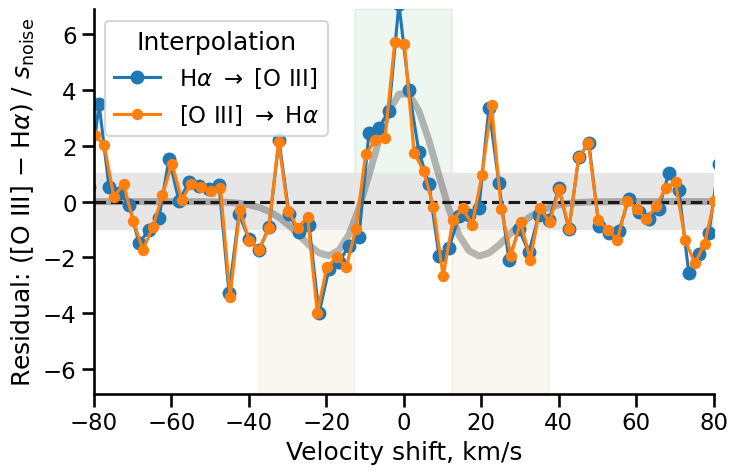

In [75]:
fig, ax = plt.subplots(figsize=(8, 5))
line, = ax.plot(vel_o, (i_o - i_ho) / s_noise, "o-", label=r"H$\alpha$ $\to$ [O III]")
# Make the next markers a bit smaller, 
# so we can still see the previous ones when they overlap
ms = 0.8 * line.get_markersize()
ax.plot(vel_h, (i_oh - i_h) / s_noise, "o-", ms=ms, label=r"[O III] $\to$ H$\alpha$")

ax.plot(vel_o, (g_o - g_ho) / s_noise, "-", 
        color="k", alpha=0.3, lw=5, zorder=-100)

ax.axhline(0, color="k", linestyle="dashed", zorder=-100)
ax.axhspan(-1, 1, color="0.9", zorder=-200)
ax.axvspan(
    -1.5 * fwhm_o, -0.5 * fwhm_o, 
    ymin=0, ymax=0.5,
    color="y", alpha=0.1, zorder=-300,
)
ax.axvspan(
    0.5 * fwhm_o, 1.5 * fwhm_o, 
    ymin=0, ymax=0.5,
    color="y", alpha=0.1, zorder=-300,
)
ax.axvspan(
    -fwhm_o / 2, fwhm_o / 2, 
    ymin=0.5, ymax=1.0,
    color="g", alpha=0.1, zorder=-300,
)
ax.legend(title="Interpolation")
ax.set_ylim(-6.9, 6.9)
ax.set_xlim(-80, 80)
ax.set_xlabel("Velocity shift, km/s")
ax.set_ylabel(r"Residual: ([O III] $-$ H$\alpha$) / $s_\mathrm{noise}$")
sns.despine()

This shows predominantly positive residual in the core (green shading) and predominantly negative residuals in the wings (yellow shading), although this latter is a lot noisier and more evident on the blue than the red side. 

*Perhaps, the subtraction of the ISM line is unduly affecting the red side. Although I do not believe this to be the case, since it looks like the issue is a real skewness in the oiii profile, which is not so prominent in H alpha. This causes the positive residuals around +20 km/s* 

I also show the residual between the two gaussian fits as the gray line, which more clearly shows the expected sombrero profile. 

Note that there is no significant difference between the two interpolations. The biggest difference is near the peak of the lines, and even there it is minor. 

### Optimum size of extraction window

Also note that I have investigated the effects of changing the size of the spatial extraction window along the slit. The differences are minor. I have chosen the window that gives the largest s/n ratio. This is 17 pixels and gives s/n of 40 for Ha and 30 for Oiii

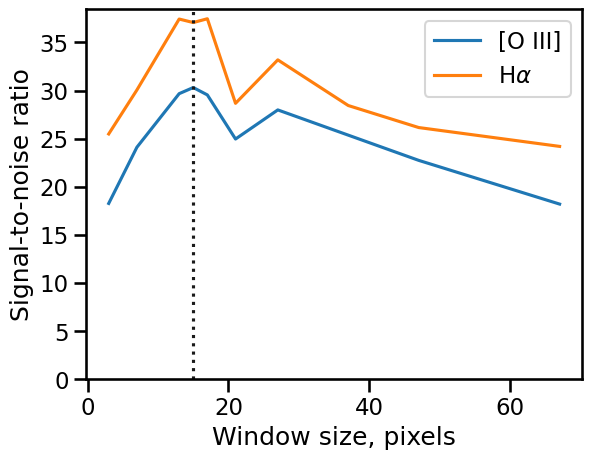

In [76]:
snr_dict = {
    +20: (24.18891367543516, 18.191910107317998),
    +10: (26.149122388238688, 22.737316274209395),
    +5: (28.438370645632812, 25.359650214159032),
    +0: (33.18584854827538, 27.982091651173654),
    -3: (28.66752546398541, 24.957199441709353),
    -5: (37.45955799870539, 29.542278496464878),
    -6: (37.065848557373215, 30.308486959837605),
    -7: (37.4287582764283, 29.671969029824634),
    -10: (30.05426089705963, 24.100198832999215),
    -12: (25.48304300176179, 18.260139961930918),
}
fig, ax = plt.subplots()
sizes = [27 + 2  * _i for _i in snr_dict]
snrs_h = [_[0] for _ in  snr_dict.values()]
snrs_o = [_[1] for _ in  snr_dict.values()]
ax.plot(sizes, snrs_o, label="[O III]")
ax.plot(sizes, snrs_h, label=r"H$\alpha$")
ax.axvline(15, color="k", linestyle="dotted")
ax.set_ylim(0, None)
ax.set_xlabel("Window size, pixels")
ax.set_ylabel("Signal-to-noise ratio")
ax.legend()


## Convolution with one-phase model

This is the practice run. Convolve with single gaussians of varying sigma. I am copying what I did in the 04-01 notebook and removing extraneous parts.

In [77]:
from astropy.convolution import convolve, Gaussian1DKernel

Work on the Oiii grid to start with. And restrict to a window of +/- 80 km/s. Normalize to the peak of the Ha profile for consistency with previous version. 

In [78]:
m = np.abs(vel_o) <= 80
vels = vel_o[m]
dv = np.diff(vels)[0]
norm = np.max(g_ho)
vprofiles = {
    "ha": i_ho[m] / norm,
    "oiii": i_o[m] / norm,
}
vsys = 0
noise_rms_diff = s_noise / norm

For the definition of the core and the wings, we use 0.5 and 1.5 times the fwhm of the Oiii line, as in the graph of the residuals above.

In [79]:
v_core = 0.5 * fwhm_o
v_wings = 1.5 * fwhm_o
is_core = np.abs(vels - vsys) <= v_core
is_line = np.abs(vels - vsys) <= v_wings
is_wings = is_line & (~is_core)

### Plot best-fit sigma

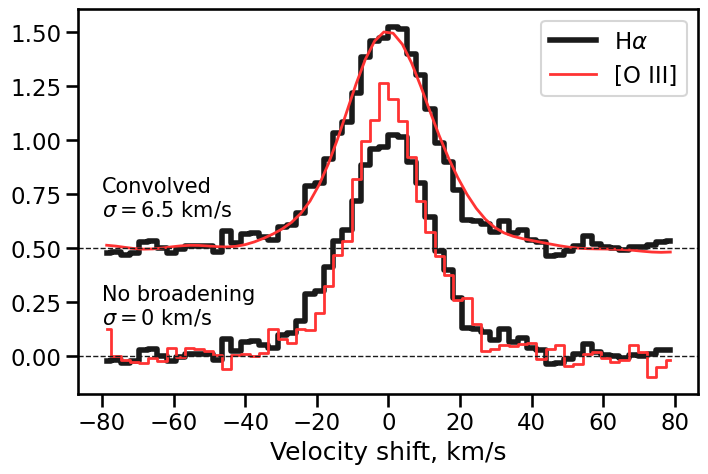

In [80]:
ss_opt = sig_extra / dv
with sns.color_palette("dark"):

    fig, ax = plt.subplots(figsize=(8, 5))
    #ds = "default"
    ds = "steps-mid"
    olw, hlw = 2, 4
    ocolor = (1, 0.2, 0.2)
    offset_step = 0.5
    offset = 0
    ax.plot(vels, offset + vprofiles["ha"], lw=hlw, color="k", ds=ds, label=r"H$\alpha$")
    ax.plot(vels, offset + vprofiles["oiii"], color=ocolor, lw=olw, ds=ds, label="[O III]")
    text = "No broadening\n" + r"$\sigma = 0$ km/s"
    ax.text(-80, offset + 0.15, text, fontsize="small")
    ax.axhline(offset, ls="dashed", color="k", lw=1)

    ds = "default"
    dsha = "steps-mid"
    offset += offset_step
    sprofile = convolve(vprofiles["oiii"], Gaussian1DKernel(stddev=ss_opt, mode="oversample"))
    ax.plot(vels, offset + vprofiles["ha"], lw=hlw, ds=dsha, color="k")
    ax.plot(vels, offset + sprofile, color=ocolor, lw=olw)
    text = "Convolved\n" + rf"$\sigma = {ss_opt * dv:.1f}$ km/s"
    ax.text(-80, offset + 0.15, text, fontsize="small")
    # ax.text(20, offset + 0.1, "A", fontsize="small")
    ax.axhline(offset, ls="dashed", color="k", lw=1)
    
    # offset += offset_step
    # sprofile = convolve(vprofiles["oiii"], Gaussian1DKernel(stddev=ss_opt_core, mode="oversample"))
    # ax.plot(vels, offset + vprofiles["ha"], lw=hlw, ds=dsha, color="k")
    # ax.plot(vels, offset + sprofile, color=ocolor, lw=olw)
    # text = "Optimize core\n" + rf"$\sigma = {ss_opt_core * dv:.1f}$ km/s"
    # ax.text(-120, offset + 0.1, text, fontsize="small")
    # ax.text(20, offset + 0.1, "B", fontsize="small")
    # ax.axhline(offset, ls="dashed", color="k", lw=1)

    # ax.axvspan(-33 - core_width, -33 + core_width, color="b", alpha=0.1, zorder=-100)
    # ax.axvline(-33, ls="dashed", color="k", lw=1)
    ax.set_xlabel("Velocity shift, km/s")
    ax.legend()
    
    # figfile = "pn-ou5-convolution-fits.pdf"
    # fig.savefig(figfile, bbox_inches="tight")
    # fig.savefig(figfile.replace(".pdf", ".jpg"), bbox_inches="tight")

### Residuals plot for different sigmas

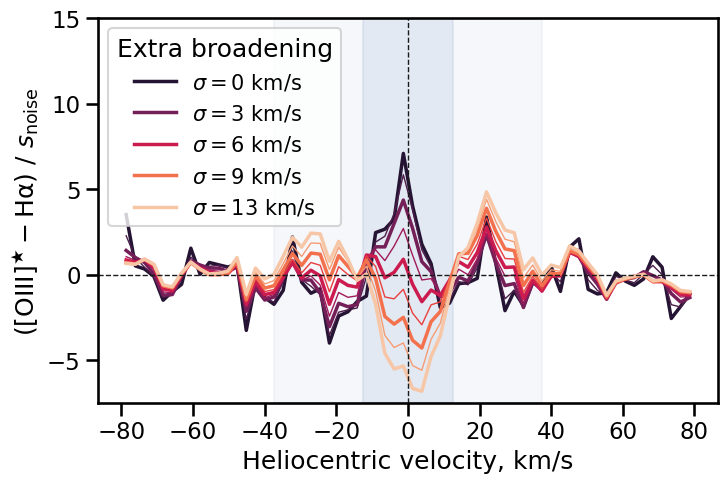

In [81]:
ss_list = np.linspace(0.0, 5.0, 50)
skip = 6
with sns.color_palette("rocket", 1 + len(ss_list) // skip):
    fig, ax = plt.subplots(figsize=(8, 5))
    sum_square_residuals = []
    sum_square_residuals_core = []
    sum_square_residuals_wings = []
    for index, ss in enumerate(ss_list):
        if ss > 0:
            sprofile = convolve(vprofiles["oiii"], Gaussian1DKernel(stddev=ss, mode="oversample"))
        else:
            sprofile = vprofiles["oiii"]
        residuals = (sprofile - vprofiles["ha"]) / noise_rms_diff
        if index % skip == 0:
            if index % (skip*2) == 0:
                label = f"$\sigma = {dv * ss:.0f}$ km/s"
                lw = 2.5
            else:
                label = None
                lw = 1.0
            ax.plot(vsys + vels, residuals, label=label, lw=lw)
        sum_square_residuals.append(np.sum(residuals[is_line]**2))
        sum_square_residuals_core.append(np.sum(residuals[is_core]**2))
        sum_square_residuals_wings.append(np.sum(residuals[is_wings]**2))
    ax.axvline(vsys, ls="dashed", color="k", lw=1)
    ax.axhline(0, ls="dashed", color="k", lw=1)
    ax.axvspan(vsys - v_wings, vsys + v_wings, color="b", alpha=0.05, zorder=-100)
    ax.axvspan(vsys - v_core, vsys + v_core, color="b", alpha=0.1, zorder=-100)
    ax.legend(fontsize="small", title="Extra broadening")
    ax.set_ylim(None, 15)
    ax.set_xlabel("Heliocentric velocity, km/s")
    ax.set_ylabel(r"$ (\mathrm{[O III]}^\bigstar - \mathrm{H\alpha})\ / \ s_\mathrm{noise}$")
    figfile = "new70-pn-ou5-convolution-residuals.pdf"
    fig.savefig(figfile, bbox_inches="tight")
    fig.savefig(figfile.replace(".pdf", ".jpg"), bbox_inches="tight")

It is clear that the red line (6 km/s smoothing) minimises the residuals in the core and in the negative wing. Nothing can improve the residuals in the positive wings, but anything larger than 6 km/s starts to make things increasingly worse.

### Graph of chi-squared versus sigma

In [82]:
npts_core = np.sum(is_core).astype(int)
npts_wings = np.sum(is_wings).astype(int)
nu_core = npts_core - 1
nu_wings = npts_wings - 1
nu_full = npts_core + npts_wings - 1
nu_core, nu_wings, nu_full

(9, 19, 29)

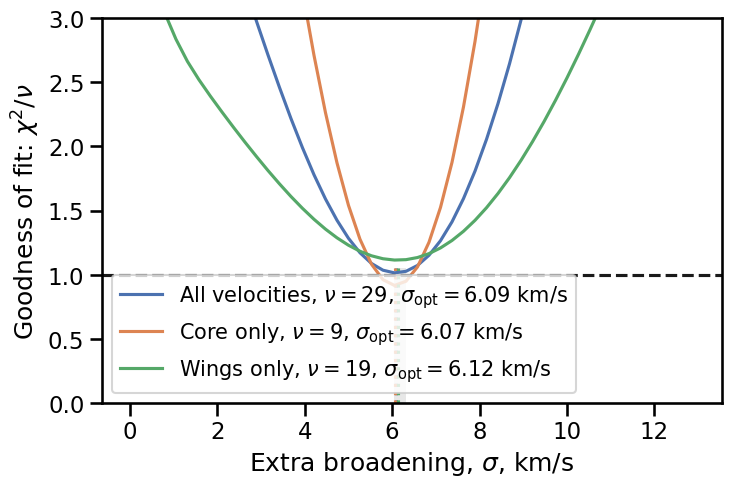

In [83]:
with sns.color_palette("deep", n_colors=3):
    fig, ax = plt.subplots(figsize=(8, 5))

    # Find the optimum by interpolating chi-square gradient=0
    ss_opt = np.interp(0.0, np.gradient(sum_square_residuals), ss_list)
    # Confidence limits for 2 points where chi-square = 1
    m = ss_list > ss_opt # divide into descending and ascending branches
    ss_plus = np.interp(1.0, np.array(sum_square_residuals)[m] / nu_full, ss_list[m])
    ss_minus = np.interp(-1.0, -np.array(sum_square_residuals)[~m] / nu_full, ss_list[~m])

    label = fr"All velocities, $\nu = {nu_full}$, $\sigma_\mathrm{{opt}} = {dv * ss_opt:.2f}$ km/s"
    line, = ax.plot(dv * ss_list, sum_square_residuals / nu_full, label=label)
    c = line.get_color()
    ax.axvline(ss_opt * dv, linestyle="dotted", color=c, ymax=0.35)
    ax.axvspan(ss_minus * dv, ss_plus * dv, color="k", lw=0, alpha=0.1, zorder=-100, ymax=0.35)
    
    ss_opt_core = np.interp(0.0, np.gradient(sum_square_residuals_core), ss_list)
    label = fr"Core only, $\nu = {nu_core}$, $\sigma_\mathrm{{opt}} = {dv * ss_opt_core:.2f}$ km/s"
    line, = ax.plot(dv * ss_list, sum_square_residuals_core / nu_core, label=label)
    c = line.get_color()
    ax.axvline(ss_opt_core * dv, linestyle="dotted", color=c, ymax=0.35)

    ss_opt_wings = np.interp(0.0, np.gradient(sum_square_residuals_wings), ss_list)
    label = fr"Wings only, $\nu = {nu_wings}$, $\sigma_\mathrm{{opt}} = {dv * ss_opt_wings:.2f}$ km/s"
    line, = ax.plot(dv * ss_list, sum_square_residuals_wings / nu_wings, label=label)
    c = line.get_color()
    ax.axvline(ss_opt_wings * dv, linestyle="dotted", color=c, ymax=0.35)

    ax.axhline(1.0, color="k", linestyle="dashed")
    ax.set_ylim(0.0, 3)
    ax.set_xlabel(r"Extra broadening, $\sigma$, km/s")
    ax.set_ylabel(r"Goodness of fit: $\chi^2 / \nu$")
    ax.legend(fontsize="small")
    figfile = "new70-pn-ou5-convolution-optimum-chi2.pdf"
    fig.savefig(figfile, bbox_inches="tight")
    fig.savefig(figfile.replace(".pdf", ".jpg"), bbox_inches="tight")

### Derived temperature with uncertainties

Mean and confidence limits on the extra sigma and the temperature

In [84]:
sigma_extra_ci = np.array([ss_minus * dv, ss_opt * dv, ss_plus * dv])
sigma_extra_ci * u.km / u.s

<Quantity [6.05414379, 6.08785383, 6.31736743] km / s>

In [85]:
T_1phase_ci = (1e4 * u.K) * (sigma_extra_ci**2 - 10.2) / 77.34
T_1phase_ci

<Quantity [3420.3073503 , 3473.23043742, 3841.36686099] K>

So that is $3500_{-1500}^{+1800}$ K, which is cooler than we got from the co-added slits, but only by about 1-sigma.

## Convolution with two-phase model

*Comment out the following once the `two_phase` module is fully stable*

In [86]:
%load_ext autoreload
%autoreload 2

### Test that the class `TwoPhaseProfile` is working

I have refactored all the two-phase machinery from the 04-01 notebook into a module `two_phase.py`. Here I test that it still works by repeating a plot from the other notebook

In [87]:
import two_phase as tp

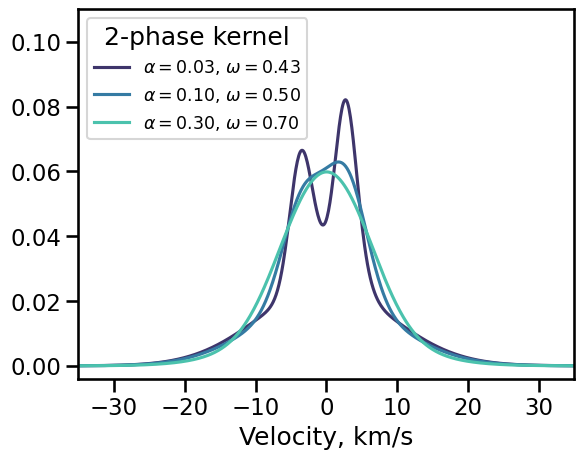

In [88]:
alist = 0.03, 0.1, 0.3
with sns.color_palette("mako", n_colors=len(alist)):
    fig, ax = plt.subplots()
    for alpha in alist:
        omega = 0.4 + alpha
        p = tp.TwoPhaseProfile(alpha, omega, dv=0.1)
        line, = ax.plot(p.vgrid - p.vmean, p.igrid,
                        label=fr"$\alpha = {alpha:.2f}$, $\omega = {omega:.2f}$")
    ax.legend(fontsize="x-small", loc="upper left", title="2-phase kernel")
    ax.set_xlim(-35, 35)
    ax.set_ylim(None, 0.11)
    ax.set_xlabel("Velocity, km/s")


### Residuals plot for different alpha and T_cool

I have implemented an `.as_kernel()` method that adapts `TwoPhaseProfile` for use with `astropy.convolution.convolve`. This makes the code in the notebook much cleaner.

First do an example with specific T_cool

Note that I have added `vsys_plot` for centering the velocities on the heliocentric systemic velocity. **However, I really should use the horizontal slit to determine the actual centroid velocity for where this slit crosses the equator**

In [89]:
om_list = np.linspace(0.0, 1.0, 41)[::-1]
skip = 5
vsys_plot = -33

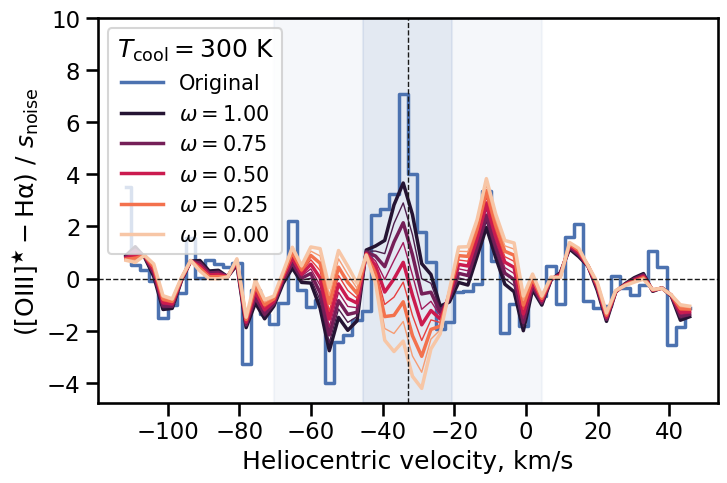

In [90]:
alpha = 0.03
with sns.color_palette("rocket", 1 + len(om_list) // skip):
    fig, ax = plt.subplots(figsize=(8, 5))
    sum_square_residuals = []
    ax.plot(vsys_plot + vels,  (vprofiles["oiii"] - vprofiles["ha"]) / noise_rms_diff, label="Original", ds="steps-mid", lw=2.5, color="b")
    for index, omega in enumerate(om_list):
        if omega is not None:
            kernel = tp.TwoPhaseProfile(alpha, omega).as_kernel(pixel_size=dv)
            sprofile = convolve(vprofiles["oiii"], kernel)
        else:
            sprofile = vprofiles["oiii"]
        residuals = (sprofile - vprofiles["ha"]) / noise_rms_diff
        if index % skip == 0:
            if index % (skip*2) == 0:
                label = f"$\omega = {omega:.2f}$"
                lw = 2.5
            else:
                label = None
                lw = 1.0
            ax.plot(vsys_plot + vels, residuals, label=label, lw=lw)
        sum_square_residuals.append(np.sum(residuals[is_line]**2))
    ax.axvline(vsys_plot, ls="dashed", color="k", lw=1)
    ax.axhline(0, ls="dashed", color="k", lw=1)
    ax.axvspan(vsys_plot - v_wings, vsys_plot + v_wings, color="b", alpha=0.05, zorder=-100)
    ax.axvspan(vsys_plot - v_core, vsys_plot + v_core, color="b", alpha=0.1, zorder=-100)
    ax.legend(fontsize="small", title=rf"$T_\mathrm{{cool}} = {10000*alpha:.0f}$ K")
    ax.set_ylim(None, 10)
    ax.set_xlabel("Heliocentric velocity, km/s")
    ax.set_ylabel(r"$ (\mathrm{[O III]}^\bigstar - \mathrm{H\alpha})\ / \ s_\mathrm{noise}$")
    alpha_id = f"a{int(100*alpha):03d}"
    figfile = f"new70-pn-ou5-2phase-{alpha_id}-convolution-residuals.pdf"
    fig.savefig(figfile, bbox_inches="tight")
    fig.savefig(figfile.replace(".pdf", ".jpg"), bbox_inches="tight")

Now do a loop over several T__cool and save all the chi-square results for later analysis. Simplify things by omitting the plots

### Chi-square curves for all the alphas

In [91]:
chisq = {}
for alpha in [0.03, 0.1, 0.3, 0.4, 0.5, 0.6]:
    sum_square_residuals = []
    for index, omega in enumerate(om_list):
        kernel = tp.TwoPhaseProfile(alpha, omega).as_kernel(pixel_size=dv)
        sprofile = convolve(vprofiles["oiii"], kernel)
        residuals = (sprofile - vprofiles["ha"]) / noise_rms_diff
        sum_square_residuals.append(np.sum(residuals[is_line]**2))
    chisq[alpha] = sum_square_residuals

For a 2-parameter model, the 95% (2 sigma) confidence level is $\delta \chi^2 \approx 6$ with respect to the best-fit model, where

See https://people.richland.edu/james/lecture/m170/tbl-chi.html

So this corresponds to the following in reduced chi2

In [92]:
min_chisq = np.min(np.stack(tuple(chisq.values())))
reduced_chisq_min = min_chisq / nu_full
reduced_chisq68 = (min_chisq + 2.3) / nu_full
reduced_chisq95 = (min_chisq + 6.17) / nu_full
reduced_chisq997 = (min_chisq + 11.8) / nu_full

reduced_chisq_min, reduced_chisq68, reduced_chisq95, reduced_chisq997

(1.0161576952740432, 1.0954680401016295, 1.2289163159636984, 1.423054246998181)

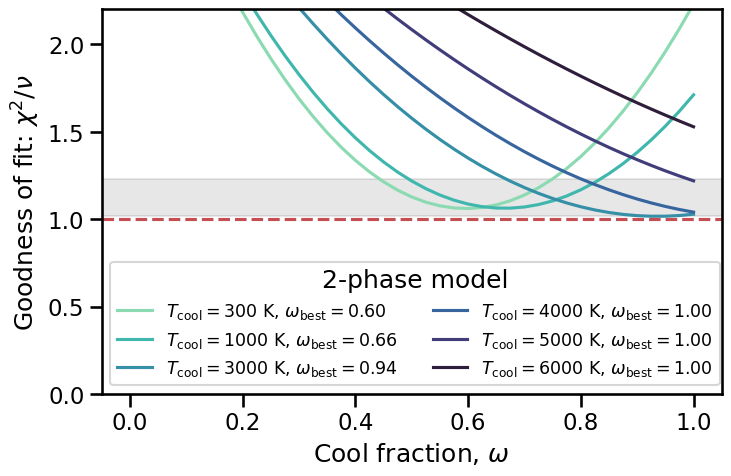

In [93]:
alphas = sorted(chisq)
omega_fits = {}
with sns.color_palette("mako_r", n_colors=len(alphas)):
        
    fig, ax = plt.subplots(figsize=(8, 5))
    for alpha in alphas:
        _chisq = np.array(chisq[alpha]) / nu_full
        
        om_opt = np.interp(0.0, np.gradient(_chisq), om_list)
        label = rf"$T_\mathrm{{cool}} = {1e4*alpha:.0f}$ K, $\omega_\mathrm{{best}} = {om_opt:.2f}$"
        line, = ax.plot(om_list, _chisq, label=label)
        c = line.get_color()
        omega_fits[alpha] = om_opt
        # ax.axvline(om_opt, linestyle="dotted", color=c, ymax=0.25)
   
    ax.axhline(1, linestyle="dashed", color="r")
    ax.set_ylim(0.0, 2.2)
    ax.axhspan(
        reduced_chisq_min, reduced_chisq95, 
        color="k", alpha=0.1, zorder=-100,
    )
    ax.set_xlabel(r"Cool fraction, $\omega$")
    ax.set_ylabel(r"Goodness of fit: $\chi^2 / \nu$")
    ax.legend(
        fontsize="x-small", 
        title="2-phase model", 
        ncol=2,
    )
    figfile = "new70-pn-ou5-2phase-multi-convolution-optimum.pdf"
    fig.savefig(figfile, bbox_inches="tight")
    fig.savefig(figfile.replace(".pdf", ".jpg"), bbox_inches="tight")

In [94]:
omega_fits

{0.03: 0.5961962172129325,
 0.1: 0.6645473348779801,
 0.3: 0.9359751653509844,
 0.4: 1.0,
 0.5: 1.0,
 0.6: 1.0}

So, this ends up being not too different from the previous version after all. 

We can exclude any model with T_cool > 5000 K, but below that all the models have reduced chi-square less than 1.

We call also exclude any models with omega < 0.4, however low T_cool is.

This means that no more than half of the H alpha emission comes from the warm component, which means that the collisional line metal abundances need to go up by a factor of two.  **This is in conflict with the Paschen jump analysis for other high-adf nebulae in García-Rojas+(2022), which found very low values for omega of 0.03**


### Contour plot of confidence limits

We can do the calculation on a finer parameter grid and then plot contours of delta chi2 to get confidence limits

In [95]:
N = 50
omega_fine = np.linspace(0.0, 1.0, N)
# alpha_fine = np.geomspace(0.03, 0.7, N)
alpha_fine = np.linspace(0.001, 0.6, N)
chisq_grid = np.empty((N, N))
for j, omega in enumerate(omega_fine):
    for i, alpha in enumerate(alpha_fine):
        kernel = tp.TwoPhaseProfile(alpha, omega).as_kernel(pixel_size=dv)
        sprofile = convolve(vprofiles["oiii"], kernel)
        residuals = (sprofile - vprofiles["ha"]) / noise_rms_diff
        chisq_grid[j, i] = np.sum(residuals[is_line]**2)
        

In [96]:
chi2_min = np.min(chisq_grid)
chi2_min

29.281177888669564

In [97]:
j0, i0 = np.unravel_index(np.argmin(chisq_grid), chisq_grid.shape)
i0, j0, chisq_grid[j0, i0]

(28, 49, 29.281177888669564)

In [98]:
Tc_best = 1e4 * alpha_fine[i0]
om_best = omega_fine[j0]
Tc_best, om_best


(3432.857142857143, 1.0)

Find optimum omega at each T_cool. Use the zero-gradient interpolation trick 

In [99]:
# Naive version has steps in it
omega_best0 = omega_fine[np.argmin(chisq_grid, axis=0)]
# Use interpolation at gradient = 0 to get a smooth version
omega_best = np.array(
    [
        np.interp(
            0.0, 
            np.gradient(chisq_grid[:, _i]), 
            omega_fine
        )
        for _i in range(N)
    ]
)
omega_best

array([0.56138433, 0.57978693, 0.59199609, 0.60319608, 0.61452082,
       0.62616171, 0.63816179, 0.65053109, 0.66327256, 0.67642938,
       0.68997171, 0.7038991 , 0.71821887, 0.7329404 , 0.74807608,
       0.76364078, 0.77965077, 0.79612454, 0.81308232, 0.83054681,
       0.84854223, 0.86709432, 0.88623144, 0.90598359, 0.92638337,
       0.94751029, 0.96939547, 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ])

In [100]:
def naive_omega(Tcool, Tmean, Twarm=10000):
    return np.minimum(1.0, (Twarm - Tmean) / (Twarm - Tcool))


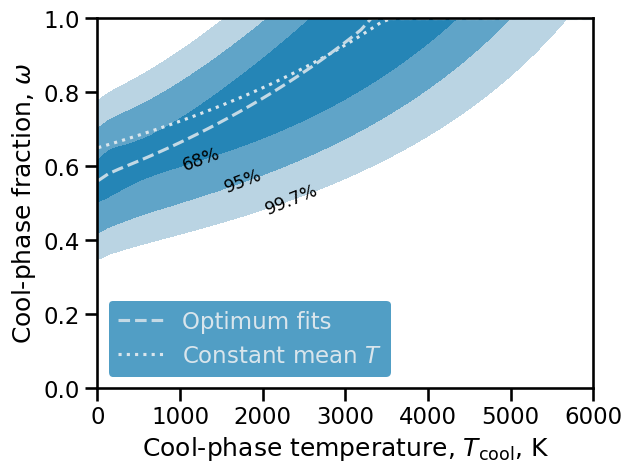

In [101]:
fig, ax = plt.subplots()
Tcool = 1e4 * alpha_fine
cmap = sns.light_palette("xkcd:nice blue", as_cmap=True, reverse=True)
CS = ax.contourf(
    1e4 * alpha_fine, omega_fine, chisq_grid,
    levels=[chi2_min, chi2_min + 2.3, chi2_min + 6.17, chi2_min + 11.8],
    cmap=cmap,
)
ax.plot(
    Tcool, naive_omega(Tcool, Tmean=3500), 
    ls="dotted", color=cmap(0.9),
    label="Constant mean $T$",
)
ax.plot(
    Tcool, omega_best, 
    ls="dashed", color=cmap(0.8),
    label="Optimum fits",
)
labels = "", "68%", "95%", "99.7%"
ax.text(1000, 0.59, labels[1], fontsize="x-small", rotation=20)
ax.text(1500, 0.53, labels[2], fontsize="x-small", rotation=21)
ax.text(2000, 0.47, labels[3], fontsize="x-small", rotation=22)
ax.set_xlim(0.0, None)
ax.set_xlabel(r"Cool-phase temperature, $T_\mathrm{cool}$, K")
ax.set_ylabel(r"Cool-phase fraction, $\omega$")
legend = ax.legend(
    reverse=True, facecolor=cmap(0.1), labelcolor=cmap(0.9),
    frameon=True, edgecolor="none",
)
figfile = "new70-pn-ou5-2phase-confidence-intervals.pdf"
fig.savefig(figfile, bbox_inches="tight")
fig.savefig(figfile.replace(".pdf", ".jpg"), bbox_inches="tight")

### Finally, plot the best-fit convolved profiles

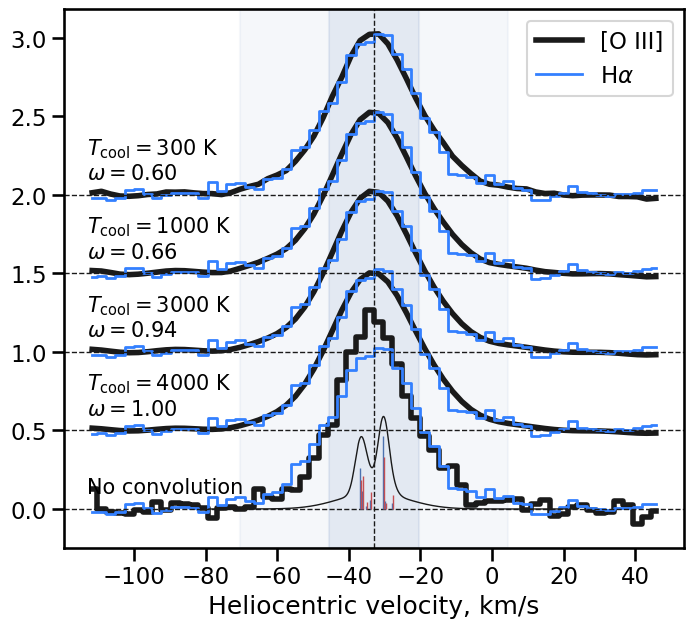

In [107]:
sns.set_color_codes()
with sns.color_palette("dark"):

    fig, ax = plt.subplots(figsize=(8, 7))
    ds = "steps-mid"
    olw, hlw = 2, 4
    ocolor = (0.2, 0.5, 1.0)
    offset_step = 0.5
    offset = 0
    ax.plot(vels + vsys_plot, offset + vprofiles["oiii"], lw=hlw, color="k", ds=ds, label="[O III]")
    ax.plot(vels + vsys_plot, offset + vprofiles["ha"], color=ocolor, lw=olw, ds=ds, label=r"H$\alpha$")
    text = "No convolution"
    ax.text(-80 + vsys_plot, offset + 0.1, text, fontsize="small")
    ax.axhline(offset, ls="dashed", color="k", lw=1)

    ds = "default"
    dsha = "steps-mid"
    for alpha in 0.4, 0.3, 0.1, 0.03:
        # Use default fallback in case I want to try very low alpha
        omega = omega_fits.get(alpha, omega_fits[0.03])
        label = fr"$T_\mathrm{{cool}} = {1e4 * alpha:.0f}$ K"
        offset += offset_step
        p = tp.TwoPhaseProfile(alpha, omega)
        kernel = p.as_kernel(pixel_size=dv)
        if alpha == 0.03:
            p300 = p # save this kernel profile for later plotting
        sprofile = convolve(vprofiles["oiii"], kernel)
        ax.plot(vels + vsys_plot, offset + sprofile, lw=hlw, color="k")
        ax.plot(vels + vsys_plot, offset + vprofiles["ha"], ds=dsha, color=ocolor, lw=olw)
        text = (label + "\n" + rf"$\omega = {omega:.2f}$")
        ax.text(-80 + vsys_plot, offset + 0.1, text, fontsize="small")
        # ax.text(0, offset + 0.15, label, fontsize="small")
        ax.axhline(offset, ls="dashed", color="k", lw=1)
        
    # Add in example kernel (300 K)
    p = p300
    ax.plot(p.vgrid - p.vmean + vsys_plot, 6 * p.igrid, color="k", lw=1)
    _norm = 1.0
    _alpha = 1.0
    _lw = 1
    for _xc, _xw, _yc, _yw in zip(p.cool.vcomps, p.warm.vcomps, p.cool.icomps, p.warm.icomps):
        # Velocity shift origin is the mean wavelength of the line at each temperature
        _xc = _xc - p.cool.vmean + vsys_plot
        _xw = _xw - p.warm.vmean + vsys_plot
        # blue bar for cool
        ax.plot([_xc, _xc], [0, _yc / _norm], lw=_lw, color="b", alpha=_alpha, solid_capstyle="butt")
        # red bar for warm
        ax.plot([_xw, _xw], [0, _yw / _norm], lw=_lw, color="r", alpha=_alpha, solid_capstyle="butt")
    
    ax.axvspan(vsys_plot - v_wings, vsys_plot + v_wings, color="b", alpha=0.05, zorder=-100)
    ax.axvspan(vsys_plot - v_core, vsys_plot + v_core, color="b", alpha=0.1, zorder=-100)
    ax.axvline(vsys_plot, ls="dashed", color="k", lw=1)
    ax.set_xlabel("Heliocentric velocity, km/s")

    ax.legend()
    
    figfile = "new70-pn-ou5-2phase-convolution-best-fits.pdf"
    fig.savefig(figfile, bbox_inches="tight")
    fig.savefig(figfile.replace(".pdf", ".jpg"), bbox_inches="tight")

So this is the final graph. It shows the full range of acceptable fits (reduced chi-squared < 1). There is very little difference b

It is apparent that once again, it is impossible to seperately determine T_cool and omega, beyond the constraints mentioned above.

For the lowest temperature, we do see a hint of asymmetry in the peak of the predicted Ha line, with the same sense as the observations. But we do not see two resovlved peaks

We can mention that the 